In [107]:
import os
import numpy as np
import h5py

from torchvision.transforms import transforms
from PIL import Image

Run this cell to decompress the compressed file containing the IM2LATEX handwritten dataset (obtained from https://im2markup.yuntiandeng.com/data/)

In [2]:
DATA_FOLDER = "IM2LATEX-100K-HANDWRITTEN"
DATA_FILE = DATA_FOLDER + ".tgz"
if not os.path.exists(DATA_FOLDER):
  !tar -xzf {DATA_FILE}
else:
  print("Handwritten folder already decompressed.")

Handwritten folder already decompressed.


In [37]:
IMAGES_FOLDER = os.path.join(DATA_FOLDER, "images")
image_filenames = os.listdir(IMAGES_FOLDER)
total_images_all = 99552
assert 99552 == len(image_filenames)

View an image from the dataset:

62247.png


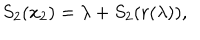

In [76]:
rand_img_filename = np.random.choice(image_filenames)
print(rand_img_filename)
Image.open(os.path.join(IMAGES_FOLDER, rand_img_filename))

Run this cell to tokenize and normalize the LaTeX formulas, if they haven't already. There will be some errors thrown, since not all formulas in the dataset can be properly parsed. That is okay, those examples are thrown out.

In [12]:
formulas_file = os.path.join(DATA_FOLDER, "formulas.lst")
formulas_norm_file = os.path.join(DATA_FOLDER, "formulas_norm.lst")
if not os.path.exists(formulas_norm_file):
  !python "scripts/preprocessing/preprocess_formulas.py" --mode normalize --input-file {formulas_file} --output-file {formulas_norm_file}
else:
  print("Formulas already normalized.")

2023-12-03 05:16:16,963 root  INFO     Script being executed: c:\Users\immen\Documents\493g\project\preprocessing\scripts\preprocessing\preprocess_formulas.py
A_{ab} \stackrel\mathrm{ def}{\equiv} \frac{\partial ^2L_\mathrm{ q}}{\partial\dot{q}_a^{n_a}\partial \dot{q}_b^{n_b}}. 
A _ { a b } \stackrel 
TypeError: Cannot read properties of undefined (reading 'type')
    at buildGroup (c:\Users\immen\Documents\493g\project\preprocessing\scripts\preprocessing\preprocess_latex.js:386:26)
    at Object.groupTypes.font (c:\Users\immen\Documents\493g\project\preprocessing\scripts\preprocessing\preprocess_latex.js:299:5)
    at buildGroup (c:\Users\immen\Documents\493g\project\preprocessing\scripts\preprocessing\preprocess_latex.js:387:31)
    at buildExpression (c:\Users\immen\Documents\493g\project\preprocessing\scripts\preprocessing\preprocess_latex.js:375:9)
    at Interface.<anonymous> (c:\Users\immen\Documents\493g\project\preprocessing\scripts\preprocessing\preprocess_latex.js:51:13)
   

Run cell below to filter out examples whose images are too big or whose formulas have grammar errors

In [56]:
max_width = 500
max_height = 160
max_tokens = 150

for dataset_type in ("train", "val", "test"):
  dataset_filename = os.path.join(DATA_FOLDER, dataset_type)
  unfiltered_filename = dataset_filename + ".lst"
  filtered_filename = dataset_filename + "_filtered.lst"
  if not os.path.exists(filtered_filename):
    !python scripts/preprocessing/preprocess_filter.py --filter --image-dir {IMAGES_FOLDER} --label-path {formulas_norm_file} --data-path {unfiltered_filename} --output-path {filtered_filename} --max-width {max_width} --max-height {max_height} --max-tokens {max_tokens}
  else:
    print(f"{dataset_type} already filtered.")

2023-12-03 06:37:34,891 root  INFO     Script being executed: c:\Users\immen\Documents\493g\project\preprocessing\scripts\preprocessing\preprocess_filter.py
2023-12-03 06:37:35,042 root  INFO     82314.png discarded due to too many tokens!
2023-12-03 06:37:35,049 root  INFO     32467.png discarded due to large image size!
2023-12-03 06:37:35,051 root  INFO     65597.png discarded due to large image size!
2023-12-03 06:37:35,063 root  INFO     66957.png discarded due to too many tokens!
2023-12-03 06:37:35,065 root  INFO     27367.png discarded due to large image size!
2023-12-03 06:37:35,066 root  INFO     96607.png discarded due to large image size!
2023-12-03 06:37:35,067 root  INFO     70269.png discarded due to large image size!
2023-12-03 06:37:35,068 root  INFO     42868.png discarded due to large image size!
2023-12-03 06:37:35,070 root  INFO     28739.png discarded due to large image size!
2023-12-03 06:37:35,073 root  INFO     39640.png discarded due to large image size!
2023-

Run cell below to generate the vocabulary for the training set:

In [57]:
train_filter_filename = os.path.join(DATA_FOLDER, "train_filtered.lst")
vocab_file = os.path.join(DATA_FOLDER, "latex_vocab.txt")
!python scripts/preprocessing/generate_latex_vocab.py --data-path {train_filter_filename} --label-path {formulas_norm_file} --output-file {vocab_file}

2023-12-03 06:38:44,234 root  INFO     Script being executed: c:\Users\immen\Documents\493g\project\preprocessing\scripts\preprocessing\generate_latex_vocab.py
2023-12-03 06:38:45,077 root  INFO     #UNK's: 33
2023-12-03 06:38:45,082 root  INFO     Jobs finished


And then get a mapping of those words to a unique number:

In [67]:
with open(vocab_file, "r") as vf:
    raw_vocab_words = vf.read().split("\n")
    vocab_words = ["[CLS]", "[EOS]", "[UNK]", "[MASK]", "[NULL]"] + raw_vocab_words
    word_to_idx = dict(zip(vocab_words, range(len(vocab_words))))

print(vocab_words[:20])

['[CLS]', '[EOS]', '[UNK]', '[MASK]', '[NULL]', '!', '"', '&', "'", '(', ')', '*', '+', ',', '-', '--', '---', '.', '/', '0']


Get every normalized formula, split by token:

In [87]:
with open(formulas_norm_file, "r") as ff:
    text_formulas = ff.read().split("\n")[:-1]
token_formulas = [l.split(" ") for l in text_formulas]

for i in range(10):
    print(token_formulas[i])

['d', 's', '^', '{', '2', '}', '=', '(', '1', '-', '{', '\\frac', '{', 'q', 'c', 'o', 's', '\\theta', '}', '{', 'r', '}', '}', ')', '^', '{', '\\frac', '{', '2', '}', '{', '1', '+', '\\alpha', '^', '{', '2', '}', '}', '}', '\\lbrace', 'd', 'r', '^', '{', '2', '}', '+', 'r', '^', '{', '2', '}', 'd', '\\theta', '^', '{', '2', '}', '+', 'r', '^', '{', '2', '}', 's', 'i', 'n', '^', '{', '2', '}', '\\theta', 'd', '\\varphi', '^', '{', '2', '}', '\\rbrace', '-', '{', '\\frac', '{', 'd', 't', '^', '{', '2', '}', '}', '{', '(', '1', '-', '{', '\\frac', '{', 'q', 'c', 'o', 's', '\\theta', '}', '{', 'r', '}', '}', ')', '^', '{', '\\frac', '{', '2', '}', '{', '1', '+', '\\alpha', '^', '{', '2', '}', '}', '}', '}', '}', '\\,', '.']
['\\widetilde', '\\gamma', '_', '{', '\\mathrm', '{', 'h', 'o', 'p', 'f', '}', '}', '\\simeq', '\\sum', '_', '{', 'n', '>', '0', '}', '\\widetilde', '{', 'G', '}', '_', '{', 'n', '}', '{', '\\frac', '{', '(', '-', 'a', ')', '^', '{', 'n', '}', '}', '{', '2', '^', '{', '

In [156]:
valid_image_names = set()
for dataset_type in ("train", "val", "test"):
  dataset_info = os.path.join(DATA_FOLDER, dataset_type + "_filtered.lst")
  with open(dataset_info, "r") as dsf:
    lines = dsf.read().split("\n")
  valid_image_names.update([l.split(" ")[0] for l in lines if len(l) > 0])

In [158]:
sizes = {}
dims = {}
for img_filename in image_filenames:
    if img_filename not in valid_image_names:
        continue
    
    with Image.open(os.path.join(IMAGES_FOLDER, img_filename)) as i:
        size = i.width * i.height
        if size not in sizes:
            sizes[size] = 0
        sizes[size] += 1
        dim = (i.height, i.width)
        if dim not in dims:
            dims[dim] = 0
        dims[dim] += 1

In [159]:
for d in sorted(dims, key=lambda a: a[0] * a[1]):
    if d[0] <= max_height and d[1] <= max_width:
        print(d, dims[d])

(50, 120) 2562
(40, 160) 4263
(40, 200) 5370
(40, 240) 5371
(50, 200) 3326
(40, 280) 4866
(50, 240) 2173
(40, 320) 4116
(50, 280) 2000
(40, 360) 3250
(50, 320) 1729
(50, 360) 1485
(50, 400) 3665
(60, 360) 18886
(100, 360) 5360
(100, 500) 12835
(160, 400) 4105


In [ ]:
small_height, small_width = 50, 240
medium_height, medium_width = 60, 360

In [116]:
datasets = {}
for dataset_type in ("train", "val", "test"):
  dataset_info = os.path.join(DATA_FOLDER, dataset_type + "_filtered.lst")
  with open(dataset_info, "r") as dsf:
    lines = dsf.read().split("\n")
  img_and_idx = [l.split(" ") for l in lines if len(l) > 0]

  num_examples = len(img_and_idx)
  img_arrays = 254 * np.ones((num_examples, 1, max_height, max_width), dtype=np.uint8)
  img_dimensions = np.zeros((num_examples, 2), dtype=np.int16)
  tokens = word_to_idx["[NULL]"] * np.ones((num_examples, max_tokens + 2), dtype=np.int16)
  tokens[:, 0] = word_to_idx["[CLS]"]
  img_filenames = np.zeros((len(img_and_idx,)), dtype=np.int32)
  formula_idxs = np.zeros((len(img_and_idx,)), dtype=np.int32)

  for i, (img_filename, formula_idx) in enumerate(img_and_idx):
    img = Image.open(os.path.join(IMAGES_FOLDER, img_filename))

    img_to_tensor = transforms.Compose([
      transforms.PILToTensor(),
      transforms.Grayscale(num_output_channels=1)
    ])
    img_tensor = img_to_tensor(img)
    img_arrays[i, 0, :img.height, :img.width] = img_tensor

    img_dimensions[i, 0] = img.height
    img_dimensions[i, 1] = img.width

    token_formula = token_formulas[int(formula_idx)]
    for j, token in enumerate(token_formula):
      tokens[i, j + 1] = word_to_idx.get(token, word_to_idx["[UNK]"])

    img_filenames[i] = int(img_filename[:-4])
    formula_idxs[i] = int(formula_idx)

  datasets[dataset_type] = {
    "N": num_examples,
    "max_width": max_width,
    "max_height": max_height,
    "max_tokens": max_tokens,
    "images": img_arrays,
    "tokens": tokens,
    "img_dimensions": img_dimensions,
    "img_filenames": img_filenames,
    "formula_idxs": formula_idxs
  }

The saved file will be pretty large (~6.4 GB), since most images don't have maximum dimensions. But, zipping it will reduce its size significantly (~180 MB). Be sure to zip it if you send it elsewhere!

In [122]:
save_to_filename = "handwritten_dataset.h5"
with h5py.File(save_to_filename, "w") as f:
    for dataset_type in ("train", "val", "test"):
        dataset_group = f.create_group(dataset_type)
        for attr in ("N", "max_width", "max_height", "max_tokens"):
            dataset_group.attrs[attr] = datasets[dataset_type][attr]
        
        for subdset_name in ("images", "tokens", "img_dimensions", "img_filenames", "formula_idxs"):
            dataset_value = datasets[dataset_type][subdset_name]
            subdset = dataset_group.create_dataset(subdset_name, dataset_value.shape, str(dataset_value.dtype))
            subdset[()] = dataset_value

In [167]:
with open("vocab_to_idx.txt", "w+") as f:
    print("\n".join([f"{word} {idx}" for word, idx in word_to_idx.items()]), end="", file=f)